In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

Using 41 systems, early-type galaxies 
$$0.2<z<0.8$$
and combining with lower-redshift SLACS sample gives virial-to-stellar mass fraction of early-type galaxies
$$(51 \pm 36)(1 + z)^{(0.9\pm1.8)}$$

In [2]:
from mejiro.lenses import lens_util

detectable_lenses = lens_util.get_detectable_lenses(config.machine.pipeline_dir, with_subhalos=True)
print(f'Number of detectable lenses: {len(detectable_lenses)}')

  0%|          | 0/975 [00:00<?, ?it/s]

100%|██████████| 975/975 [00:08<00:00, 119.53it/s]

Number of detectable lenses: 975


In [3]:
lens_stellar_masses = [l.lens_stellar_mass for l in detectable_lenses]
main_halo_masses = [l.lens_stellar_mass * 51 * (1 + l.z_lens) ** 0.9 for l in detectable_lenses]

old_main_halo_masses = []
a = 0.13
b = 0.54
for lens in detectable_lenses:
    f_dm = a * np.log10(lens.lens_stellar_mass / 1e11) + b
    main_halo_mass = lens.lens_stellar_mass / (1 - f_dm)
    old_main_halo_masses.append(main_halo_mass)

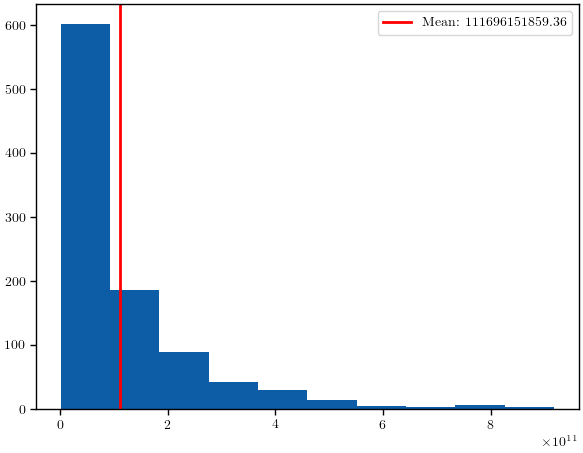

In [9]:
plt.hist(lens_stellar_masses)
plt.axvline(np.mean(lens_stellar_masses), label=f'Mean: {np.mean(lens_stellar_masses):.2f}', color='r')
plt.legend()
plt.show()

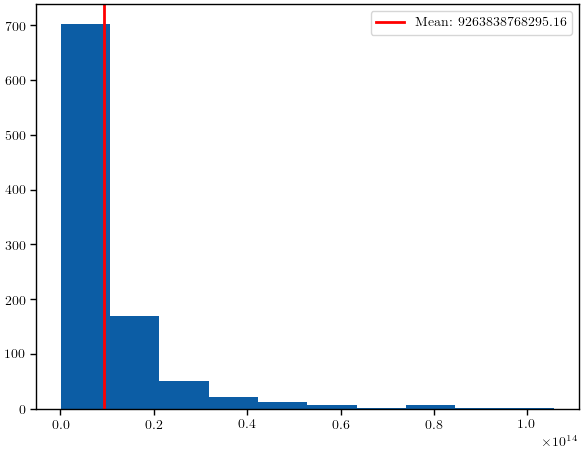

In [4]:
plt.hist(main_halo_masses)
plt.axvline(np.mean(main_halo_masses), label=f'Mean: {np.mean(main_halo_masses):.2f}', color='r')
plt.legend()
plt.show()

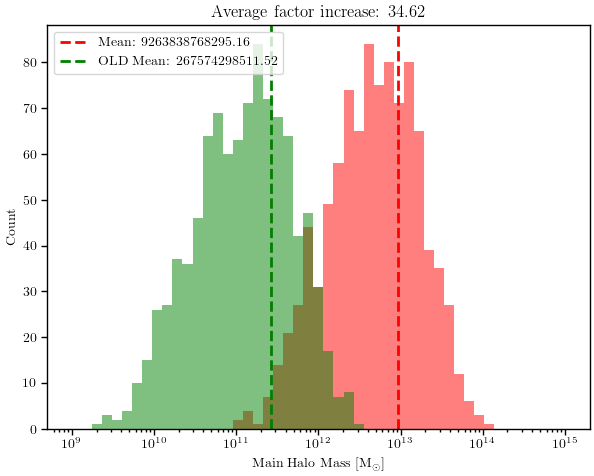

In [5]:
mean_main_halo_mass = np.mean(main_halo_masses)
mean_old_main_halo_mass = np.mean(old_main_halo_masses)

plt.hist(main_halo_masses, color='r', bins=np.logspace(9, 15, 50), alpha=0.5)
plt.hist(old_main_halo_masses, color='g', bins=np.logspace(9, 15, 50), alpha=0.5)
plt.axvline(np.mean(mean_main_halo_mass), label=f'Mean: {np.mean(mean_main_halo_mass):.2f}', color='r', linestyle='--')
plt.axvline(mean_old_main_halo_mass, label=f'OLD Mean: {mean_old_main_halo_mass:.2f}', color='g', linestyle='--')
plt.title(f'Average factor increase: {mean_main_halo_mass / mean_old_main_halo_mass:.2f}')
plt.xscale('log')
plt.xlabel('Main Halo Mass [M$_\odot$]')
plt.ylabel('Count')
plt.legend()
plt.savefig(os.path.join(figure_dir, 'main_halo_mass_calculation_comparison.png'))
plt.show()

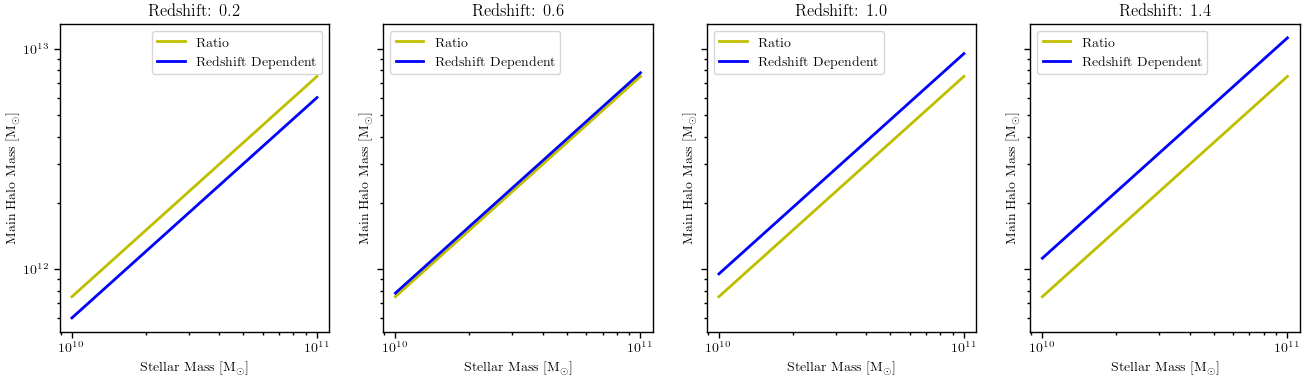

In [13]:
f, ax = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

stellar_masses = np.logspace(10, 11, 100)
redshift_list = [0.2, 0.6, 1.0, 1.4]


def redshift_dependent_main_halo_mass(stellar_mass, redshift):
    return stellar_mass * 51 * (1 + redshift) ** 0.9


for i, redshift in enumerate(redshift_list):
    ax[i].loglog(stellar_masses, [75 * m for m in stellar_masses], label='Ratio', color='y')
    ax[i].loglog(stellar_masses, [redshift_dependent_main_halo_mass(m, redshift) for m in stellar_masses],
                 label='Redshift Dependent', color='b')
    ax[i].set_title(f'Redshift: {redshift}')
    ax[i].set_xlabel('Stellar Mass [M$_\odot$]')
    ax[i].set_ylabel('Main Halo Mass [M$_\odot$]')
    ax[i].legend()

plt.savefig(os.path.join(figure_dir, 'main_halo_mass_redshift_dependence.png'))
plt.show()